###### 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.	오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
###### 2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.	gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
###### 3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.	모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.


In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.18.0
2.36.0


STEP 1. 작업환경 구성하기


In [3]:
# ! mkdir "C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\generated_samples" 
# ! mkdir "C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\training_checkpoints" 
# ! mkdir C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\training_history"

STEP 2. 데이터셋 구성하기


In [4]:
import tensorflow as tf

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [5]:
train_x = (train_x / 127.5) - 1

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


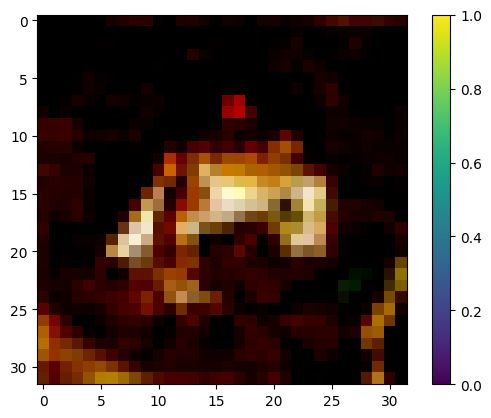

In [6]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7647058823529411..0.8980392156862744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9921568627450981..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9215686274509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764705882352941..0.9764705882352942].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Go

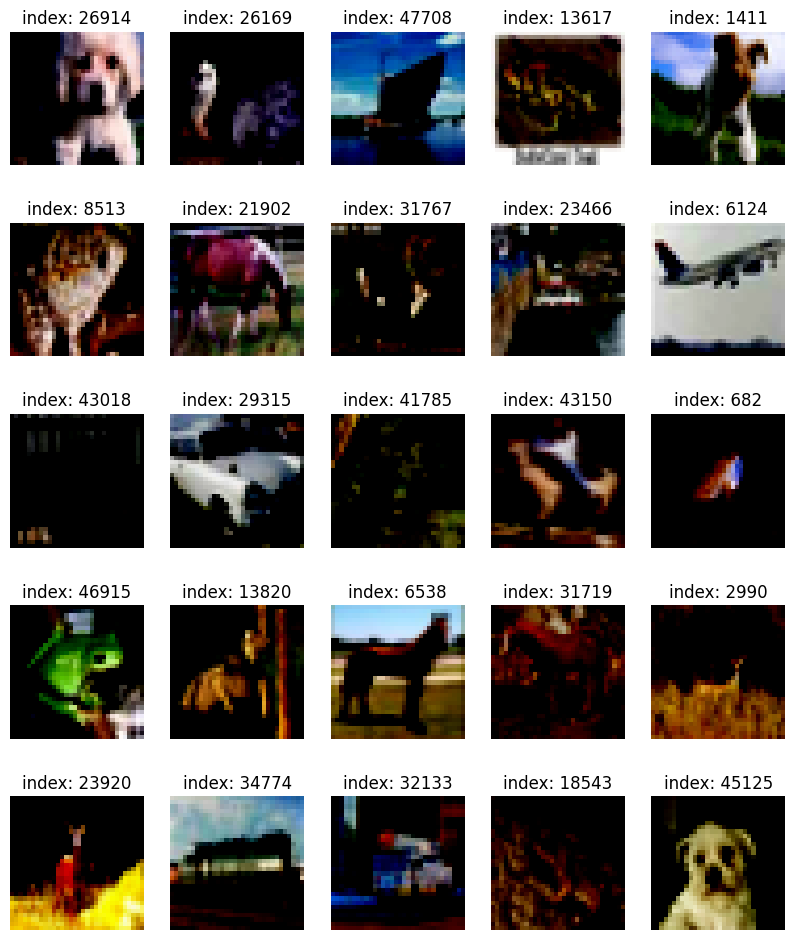

In [7]:
# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow((train_x[i] + 1) / 2)  # Rescale to [0, 1] for display
#     plt.axis('off')
# plt.show()

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

STEP 3. 생성자 모델 구현하기


In [10]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # [First] Dense layer (units=8*8*256, no bias, input shape=100)
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # [Second] Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # [Third] Conv2DTranspose (kernel_size=5, strides=2, padding='same', no bias)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # [Fourth] Conv2DTranspose (kernel_size=5, strides=2, padding='same', no bias)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # [Fifth] Conv2DTranspose (output layer: 1 channel, tanh activation)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False, 
                                     activation='tanh'))
    
    
    return model

In [11]:
generator = make_generator_model()

generator.summary()

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [12]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

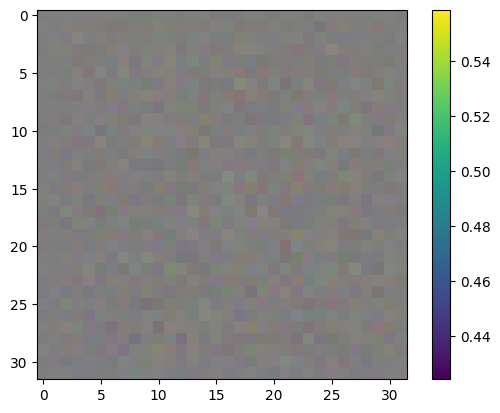

In [13]:
# scaled_image = (generated_image[0, :, :, :] + 1) / 2.0
plt.imshow(generated_image[0]+1/2.0)
plt.colorbar()
plt.show()

STEP 4. 판별자 모델 구현하기


In [14]:
def make_discriminator_model():
 
    model = tf.keras.Sequential()

    # [First] Conv2D layer (filters=64, kernel_size=5, strides=2, padding='same')
    # LeakyReLU activation + Dropout(0.3)
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), 
                            padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # [Second] Conv2D layer (filters=128, kernel_size=5, strides=2, padding='same')
    # LeakyReLU activation + Dropout(0.3)
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), 
                            padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # [Third] Flatten layer
    model.add(layers.Flatten())
    
    # [Fourth] Dense layer (output: 1)
    model.add(layers.Dense(1))
    
    return model
# ...

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,985 (851.50 KB)

 Trainable params: 217,985 (851.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00040734]], dtype=float32)>

STEP 5. 손실함수와 최적화 함수 구현하기


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [24]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [25]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 7])>

STEP 6. 훈련과정 상세 기능 구현하기


In [26]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # (2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # (3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  # (4) generated_images 생성

        # (5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)  

        # (6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output) 

        # (7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
    
    # (8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables) 

    # (9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # (10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig(r'C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\generated_samples\sample_epoch_{:04d}_iter_{:03d}.png'
                .format(epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
   
    plt.savefig(r'C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\training_history\train_history_{:04d}.png'.format(epoch))
    plt.show()

In [29]:
checkpoint_dir = r'C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

STEP 7. 학습 과정 진행하기


In [31]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

In [32]:
# # 기존 코드...
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# # ...
# # 모델 컴파일 및 기타 설정 부분...

# # EarlyStopping과 ReduceLROnPlateau 콜백 정의
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     verbose=1
# )

# # 모델 학습 부분 예시
# history = model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=val_dataset,  # val_dataset이 있다면 추가
#     callbacks=[early_stopping, reduce_lr],
# )

# # ...
# # 나머지 코드는 그대로 유지

In [33]:
# # ... 기존 코드는 그대로 ...
# def train(dataset, epochs, save_every):
#     start = time.time()
#     history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}

#     # 예: manual early stopping 설정
#     patience = 5
#     wait = 0
#     best_val_loss = float('inf')
#     best_gen_weights = None  # 예시: 생성기 가중치 저장 변수
#     # best_disc_weights = None  # 판별기도 저장하려면 필요

#     for epoch in range(epochs):
#         epoch_start = time.time()
#         for it, image_batch in enumerate(dataset):
#             gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
#             # ... 나머지 기존 코드 유지 ...
        
#         # (optional) validation loss 계산 로직이 있다면, val_loss를 얻어와야 함
#         # val_loss = ...
#         val_loss = get_validation_loss()  # 예시
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             wait = 0
#             # 필요하다면 가중치 저장
#             best_gen_weights = generator.get_weights()
#             # best_disc_weights = discriminator.get_weights()
#         else:
#             wait += 1
#             if wait >= patience:
#                 print("EarlyStopping triggered. Restoring best weights.")
#                 if best_gen_weights is not None:
#                     generator.set_weights(best_gen_weights)
#                     # discriminator.set_weights(best_disc_weights)
#                 break

#         # ... 기존 코드 (save_every 저장, 이미지 출력 등) ...

#     print("Training finished. Total time:", int(time.time() - start), "sec")
# # ...

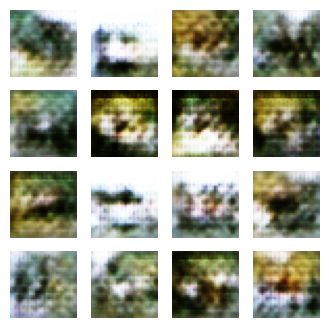

Time for training : 9020 sec


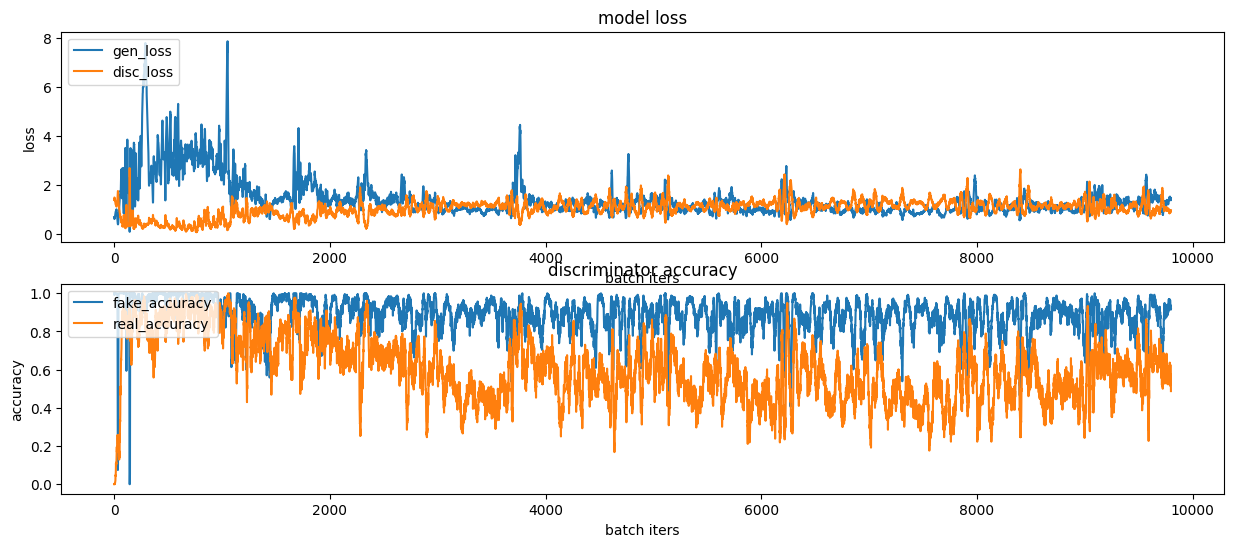

CPU times: total: 17h 35min 56s
Wall time: 2h 30min 21s


In [34]:
%%time
train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 /dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [35]:
# import imageio.v2 as imageio
anim_file = r'C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(r'C:\Users\User\Documents\GitHub\mlops\4_Image Generation_GAN\dcgan_newimage\cifar10\generated_samples\sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)



C:\Users\User\AppData\Local\Temp\ipykernel_144296\727262828.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\User\AppData\Local\Temp\ipykernel_144296\727262828.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


STEP 8. (optional) GAN 훈련 과정 개선하기